# Test 1: How much does HRRR matter, really?
We'll train a model with AirNow data only. All the preprocessing should already be done for us.

## AirNow preprocessing

In [1]:
# define bounding box
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# input data shape
dim = 40
frames_per_sample = 5

# date range of data
start_date, end_date = "2025-01-10-00", "2025-01-17-00"

In [2]:
from libs.airnowdata import AirNowData
AD = AirNowData(
    start_date=start_date,
    end_date=end_date,
    extent=extent,
    airnow_api_key=None,
    save_dir='data/airnow.json',
    frames_per_sample=frames_per_sample,
    dim=dim
)

'data/airnow.json' already exists; skipping request...


In [3]:
X_airnow = AD.data
Y = AD.target_stations
print(X_airnow.shape)
print(Y.shape)

(164, 5, 40, 40, 1)
(164, 6)


## Joint preprocessing
- Split into train/test sets
- Scale train/test sets independently
- Combine X datasets into 1 with 2 channels

In [4]:
# split data
def train_test_split(X, train_size=0.75):
    split_idx = int(X.shape[0] * train_size)
    X_train, X_test = X[:split_idx], X[split_idx:]
    
    return X_train, X_test

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

In [5]:
import numpy as np

# split data
X_airnow_train, X_airnow_test = train_test_split(X_airnow, train_size=0.75)
y_train, y_test = train_test_split(Y, train_size=0.75)

# scale training data, then test data based on training data's stats
X_train, X_test = std_scale(X_airnow_train, X_airnow_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(123, 5, 40, 40, 1) (41, 5, 40, 40, 1)
(123, 6) (41, 6)


## Final input viz

Displaying frames for example 102.


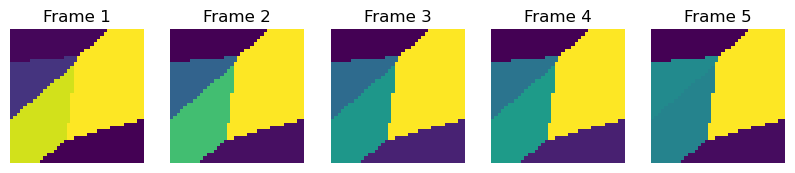

Target:  [ 2.  11.1 11.2 19.7  0.   4.8]


In [6]:
import matplotlib.pyplot as plt

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 5, figsize=(10, 4))

# Plot each of the sequential images for one random data example.
# plot hrrr channel
np.random.seed(42)
rand_sample = np.random.choice(range(len(X_train)), size=1)[0]
for idx, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

print("Target: ", y_train[rand_sample])

## Model

In [7]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

2025-04-11 17:38:15.158250: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 17:38:15.166098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744418295.176311   96699 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744418295.179641   96699 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 17:38:15.189569: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [8]:
print(X_airnow_train.shape, X_airnow_test.shape, y_train.shape, y_test.shape)

(123, 5, 40, 40, 1) (41, 5, 40, 40, 1) (123, 6) (41, 6)


In [9]:
tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=(5, 40, 40, 1))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())

seq.add(Dense(6,activation='relu'))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

I0000 00:00:1744418296.300733   96699 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 728 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        48,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,997 (460.93 KB)

 Trainable params: 117,997 (460.93 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
seq.fit(X_airnow_train, y_train, batch_size=16, epochs=150)

Epoch 1/150


I0000 00:00:1744418298.745406   96766 service.cc:148] XLA service 0x641033da3440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744418298.745424   96766 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-11 17:38:18.797766: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744418299.078588   96766 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-11 17:38:19.480712: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[16,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 12.5045

I0000 00:00:1744418301.260540   96766 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-11 17:38:22.038436: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[11,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-11 17:38:22.174616: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,15,40,40]{3,2,1,0}, u8[0]{0}

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - loss: 12.3718
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.7684
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.1484
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.2957
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.1834
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.0475
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.0637
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.8162
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.5648
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.2029
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.1908
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.5728
Epoch 13/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.6390
Epoch 14/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.7486
Epoch 15/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.4054
Epoch 16/150
8/8 ━━━━━━━━━━━━

## Results

In [11]:
y_pred = seq.predict(X_airnow_test, verbose=0)

2025-04-11 17:38:58.155261: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,40,40]{3,2,1,0}, f32[15,1,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-11 17:38:58.203999: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

In [12]:
from skimage.metrics import mean_squared_error as mse

def rmse(y_pred, y_test):
    return np.sqrt(mse(y_pred, y_test))

def nrmse(y_pred, y_test):
    return rmse(y_pred, y_test) / np.mean(y_test) * 100
    
print("Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data")
print("Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) \n")

print("RESULTS")
print("---------------------------------------------------------------------------")
print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

print("RESULTS BY FRAME")
print("---------------------------------------------------------------------------")
for i in range(5):
    print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
    print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

print("RESULTS BY SENSOR LOCATION")
print("---------------------------------------------------------------------------")
for i, loc in enumerate(list(AD.air_sens_loc.keys())):
    print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
    print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data
Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 4.34
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 45.00%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 2.80
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 23.24%

Frame 2 (Hour 2) All Locations - Raw RMSE: 2.05
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 17.69%

Frame 3 (Hour 3) All Locations - Raw RMSE: 1.76
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 14.46%

Frame 4 (Hour 4) All Locations - Raw RMSE: 2.19
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 17.67%

Frame 5 (Hour 5) All Locations 

## Visualization

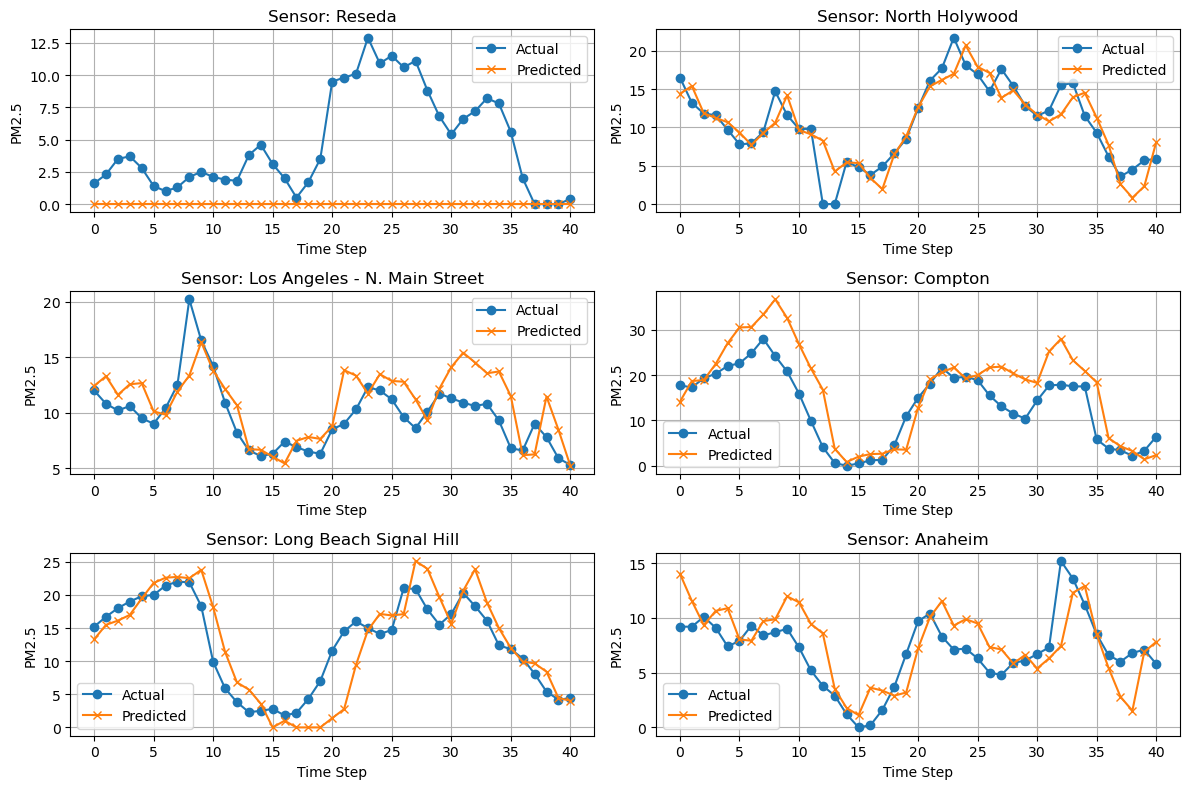

In [13]:
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(AD.air_sens_loc.keys()):
    plt.subplot(3, 2, i + 1)
    plt.plot(y_test[:, i], label='Actual', marker='o')
    plt.plot(y_pred[:, i], label='Predicted', marker='x')
    plt.title(f'Sensor: {sensor}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

Ideas: Seems like HRRR is just noise. Also, what is going on with Reseda? The training data doesn't seem off?
- When I first trained the model, long beach was okay; now this run, all the preds are 0? I think there needs to be model tweaks, i don't think it's the data. I recall one time where Reseda preds had some movement on a different training run.